# Resampling Methods
BERN02

Student: Simona Anghelina

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from scipy.special import factorial

# Cross Validation

* **Data set**: `pollution_cleaneddata.csv`

* **Task**: Use resampling methods to evaluate the predictive performance of alternative model chocies.


  1. Load the data set.
  2. Specify a polynomial regression model with degrees $p$ that predict mortality as a function of the average July temperature in degrees F.

 <center> $y_i=\beta_0+\beta_1x_i+\beta_2x_i^2+...+\beta_px_i^p$

In [ ]:
# Load the data
file_path = '/content/drive/MyDrive/BERN02/pollution_cleaneddata.csv'
data = pd.read_csv(file_path)
data.head()

,PREC,JANT,JULT,OVR65,POPN,EDUC,HOUS,DENS,NONW,WWDRK,POOR,HC,NOX,SO@,HUMID,MORT
0,36.0,27.0,71.0,8.1,3.34,11.4,81.5,3243.0,8.8,42.6,11.7,21.0,15.0,59.0,59.0,921.870
1,35.0,23.0,72.0,11.1,3.14,11.0,78.8,4281.0,3.5,50.7,14.4,8.0,10.0,39.0,57.0,997.875
2,44.0,29.0,74.0,10.4,3.21,9.8,81.6,4260.0,0.8,39.4,12.4,6.0,6.0,33.0,54.0,962.354
3,47.0,45.0,79.0,6.5,3.41,11.1,77.5,3125.0,27.1,50.2,20.6,18.0,8.0,24.0,56.0,982.291
4,43.0,35.0,77.0,7.6,3.44,9.6,84.6,6441.0,24.4,43.7,14.3,43.0,38.0,206.0,55.0,1071.289


In [ ]:
# Extract the relevant variables
X = data['JULT']  # Average July temperature in degrees F
y = data['MORT']  # Total age-adjusted mortality rate per 100,000

In [ ]:
X.shape, y.shape

((60,), (60,))

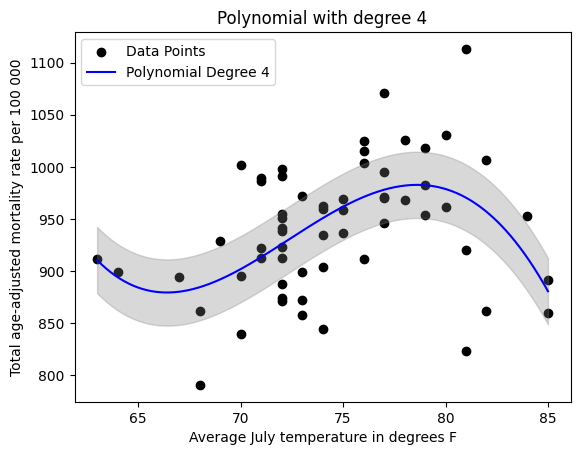

In [ ]:
# Define the polynomial degree
degree = 4

# Create polynomial features
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X.values.reshape(-1, 1))

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict on the training data (X) and calculate the MSE
y_train_pred = model.predict(X_poly)

# Create a smoother range for visualization
X_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
X_range_poly = poly.transform(X_range)

# Predict over the smoother range for visualization
y_range_pred = model.predict(X_range_poly)

#Visualize the result
plt.scatter(X, y, color='black', label='Data Points')
plt.plot(X_range, y_range_pred, color='blue', label=f'Polynomial Degree {degree}')
plt.fill_between(X_range.flatten(), y_range_pred - np.std(y_train_pred), y_range_pred + np.std(y_train_pred), color='gray', alpha=0.3)
plt.title(f'Polynomial with degree {degree}')
plt.xlabel('Average July temperature in degrees F')
plt.ylabel('Total age-adjusted mortality rate per 100 000')
plt.legend()
plt.show()

# Validation Set Approach

  3. Set a seed for the random generator.
  4. Split data into two equal sized sets, one for training and one for testing.
  5. For polynomial models with degree 1 up to 4, derive the mean square error of prediction for the training and testing data sets, respectively. Present the results into a plot with polynomial degree on the x-axis and Mean Square Error on the y-axis.


In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize lists to store MSE values for different polynomial degrees
degrees = [1, 2, 3, 4]
train_mse = []
test_mse = []

# For each polynomial degree, fit the model and calculate MSE
for degree in degrees:
  # Create polynomial featires for the current degree
  poly = PolynomialFeatures(degree=degree)

  # Transform the training and testing data
  X_train_poly = poly.fit_transform(X_train.values.reshape(-1, 1))
  X_test_poly = poly.transform(X_test.values.reshape(-1, 1))

  # Fit the model
  model = LinearRegression()
  model.fit(X_train_poly, y_train)

  # Predict on both the training and testing data
  y_train_pred = model.predict(X_train_poly)
  y_test_pred = model.predict(X_test_poly)

  # Calculate MSE for both training and testing data
  train_mse.append(mean_squared_error(y_train, y_train_pred))
  test_mse.append(mean_squared_error(y_test, y_test_pred))

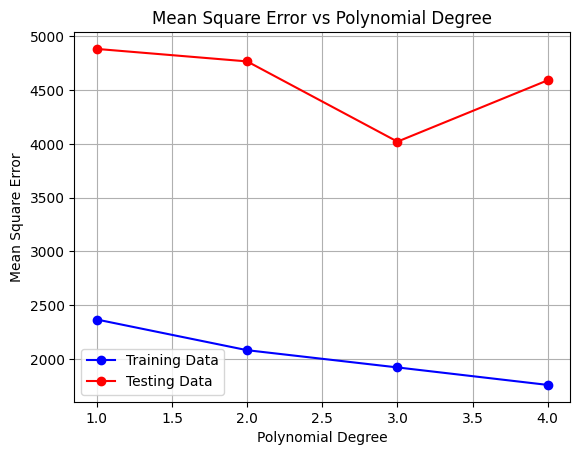

In [ ]:
# Plot the results
plt.plot(degrees, train_mse, label='Training Data', marker='o', color='blue')
plt.plot(degrees, test_mse, label='Testing Data', marker='o', color='red')
plt.title('Mean Square Error vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Square Error')
plt.legend()
plt.grid(True)
plt.show()

**Observations**:
* The training MSE (blue) decreases as the polynomial degree increases, which is expected since higher-degree polynomials can better fit the training data.
* The testing MSE (red) shows a different pattern, intitially decreasing and then increasing again after degree 3. This suggests that after a certain point (degree 3 in this case), the model starts to overfit the training data, leading to worse generalization on the test data. For degrees 1 and 2, the testing error is relatively high, which suggests that the model underfits the data, while for degree 4, the testing MSE increases again, indicating overfitting.

  6. Judging from the graph you just generated, which degree of the polynomial would you recommend if the goal is the have a small variance of new predictions.

  Based on the graph, the best polynomial degree to minimize the variance while maintaining good predictive performance would likely be `degree 3`.

  7. Repeat the procedure ten times but with other random seeds. Do you get similar results for other seeds?

In [ ]:
# Repeat the procedure 10 times with different random seeds
seeds = np.random.randint(0, 1000, 10) # Generating 10 random seeds

# Store MSE results
results = {seed: {'train': [], 'test': []} for seed in seeds}

# Repeat the procedure for each seed
for seed in seeds:
  np.random.seed(seed)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

  train_mse = []
  test_mse = []

  for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train.values.reshape(-1, 1))
    X_test_poly = poly.transform(X_test.values.reshape(-1, 1))

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))

  results[seed]['train'] = train_mse
  results[seed]['test'] = test_mse

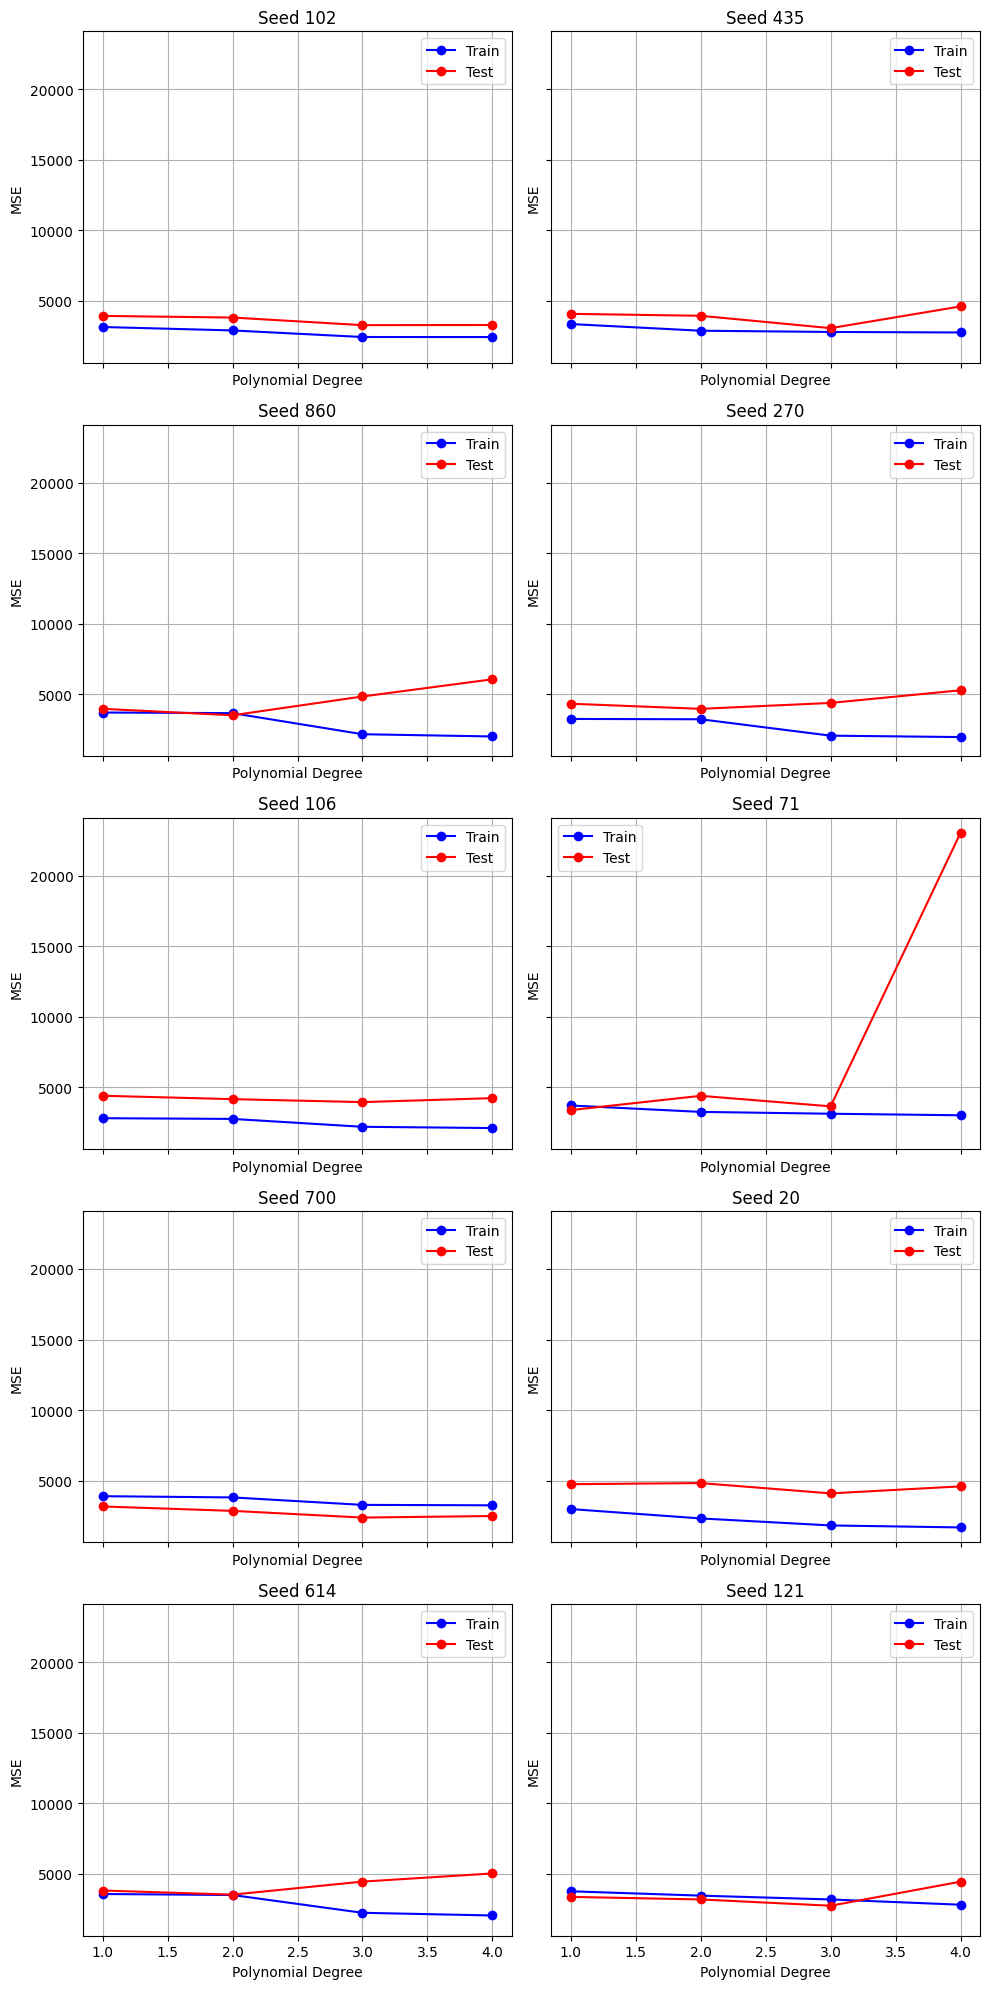

In [ ]:
# Create a 5x2 grid of plots (5 rows, 2 columns) for each seed
fig, axes = plt.subplots(5, 2, figsize=(10, 20), sharex=True, sharey=True)

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot for each seed
for idx, seed in enumerate(seeds):
    ax = axes[idx]
    ax.plot(degrees, results[seed]['train'], label='Train', marker='o', color='blue')
    ax.plot(degrees, results[seed]['test'], label='Test', marker='o', color='red')
    ax.set_title(f'Seed {seed}')
    ax.set_xlabel('Polynomial Degree')
    ax.set_ylabel('MSE')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

  In the plot above, the variability in results across different random seeds is shown.

  Each time one splits the data into training and test sets, one is likely getting different subsets of the data. This randomness in splitting can affect model's performance. Some splits may create more balanced sets, while others might generate uneven split which can lead to more noticeable differences in performance.

  In the plots where a large spike in the test MSE appears for higher-degree polynomials, this is a sign of overfitting which means that the model is not able to generalize on the test set.

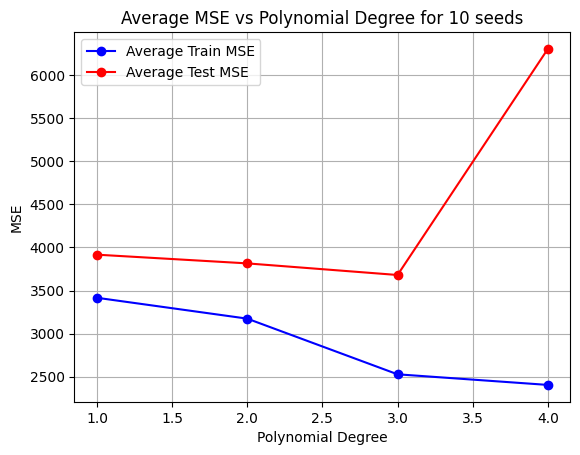

In [ ]:
# Plot the average and range of MSE across the 10 seeds
avg_train_mse = np.mean([results[seed]['train'] for seed in seeds], axis=0)
avg_test_mse = np.mean([results[seed]['test'] for seed in seeds], axis=0)

plt.plot(degrees, avg_train_mse, label='Average Train MSE', marker='o', color='blue')
plt.plot(degrees, avg_test_mse, label='Average Test MSE', marker='o', color='red')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Average MSE vs Polynomial Degree for 10 seeds')
plt.legend()
plt.grid(True)
plt.show()

  A plot containing the average result is shown above.

  It may be noticed that the average result is close to the initial result because averaging across multiple random seeds can smooth the variability.

  The randomness in train-test splits introduce variance in the MSE values across different seeds, but the structure of the data remains the same. By averaging the results, one reduces the impact of splits that generate extreme MSE values.

  As a result, the average MSE smooth out and become similar to what was observed above in the initial result with only one seed.

# K-fold Cross-Validtaion

  8. Select a polynomial degree, e.g. $p=2$. Estimate the variance of predictions using the K-fold cross-validation approach where you hold out $K=3$ sets.



In [ ]:
# Set the polynomial degree to 2
degree = 2

# Initialize KFold with K=3
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# List to store the errors
errors = []

# Perform K-Fold Cross Validation:
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # Create polynomial features
  poly = PolynomialFeatures(degree=degree)
  X_train_poly = poly.fit_transform(X_train.values.reshape(-1, 1))
  X_test_poly = poly.transform(X_test.values.reshape(-1, 1))

  # Fit the model
  model = LinearRegression()
  model.fit(X_train_poly, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test_poly)

  # Compute the MSE
  mse = mean_squared_error(y_test, y_pred)
  errors.append(mse)

# Compute the average variance of the prediction error
variance_predictions = np.mean(errors)
print(f"Average variance of the predictions across {kf.get_n_splits()} folds: {variance_predictions:.3f}")


Average variance of the predictions across 3 folds: 4256.509


  9. Repeat the procedure ten times but with other random seeds. Do you get similar results for other seeds?

In [ ]:
seeds = np.random.randint(0, 100, 10)  # Generate 10 random seeds

# List to store variances for each run with different random seeds
variances = []

# Perform the loop for each random seed
for seed in seeds:
    # Initialize KFold with K=3 for each seed
    kf = KFold(n_splits=3, shuffle=True, random_state=seed)

    # List to store errors for each fold
    errors = []

    # K-Fold Cross Validation:
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create polynomial features
        poly = PolynomialFeatures(degree=2)
        X_train_poly = poly.fit_transform(X_train.values.reshape(-1, 1))
        X_test_poly = poly.transform(X_test.values.reshape(-1, 1))

        # Fit the model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test_poly)

        # Compute the MSE
        mse = mean_squared_error(y_test, y_pred)
        errors.append(mse)

    # Compute the variance of the predictions (MSEs) for this seed
    variance_of_predictions = np.mean(errors)
    variances.append(variance_of_predictions)

# Display the variances across different random seeds
for i, seed in enumerate(seeds):
    print(f"Average variance of predictions for seed {seed}: {variances[i]:.3f}")

Average variance of predictions for seed 66: 5829.205
Average variance of predictions for seed 85: 3503.085
Average variance of predictions for seed 8: 3576.517
Average variance of predictions for seed 95: 3539.189
Average variance of predictions for seed 65: 3562.427
Average variance of predictions for seed 52: 4539.949
Average variance of predictions for seed 83: 3646.621
Average variance of predictions for seed 96: 3589.086
Average variance of predictions for seed 46: 3631.471
Average variance of predictions for seed 34: 3796.102


  The high variance in the predictions can be due to
 the random seeds which can create very different splits, leading to really different model performance on each fold.

# Bootstrap

  Use the bootstrap to estimate the standard error of the slope of the line in the Poisson regression of the birds over time.

  10. Load the data set `bird_count.csv`.


In [ ]:
# Load the data
file_path = '/content/drive/MyDrive/BERN02/bird_count.csv'
bird_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
bird_data.head()

,count,yr,observerAge,lineCov
0,2,2011,63,1.000000
1,5,2010,64,0.987500
2,12,2002,30,0.991667
3,12,2006,60,0.987500
4,5,2008,62,0.987500


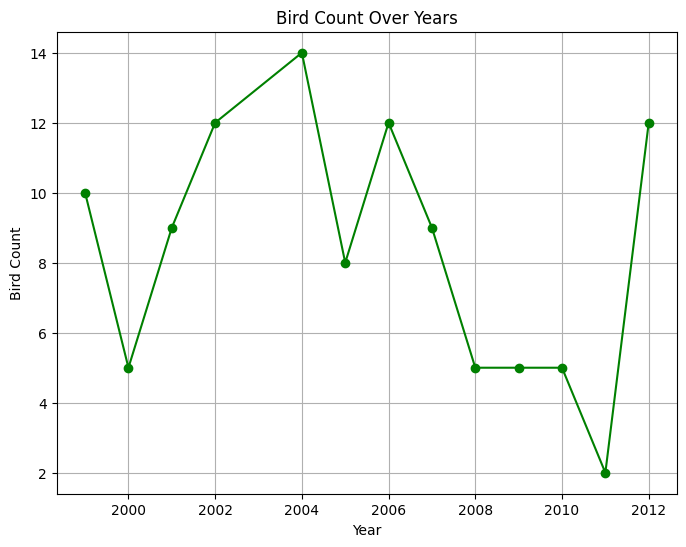

In [ ]:
# Sort the data by 'Year'
bird_data = bird_data.sort_values(by='yr')

# Make the plot
plt.figure(figsize=(8, 6))
plt.plot(bird_data['yr'], bird_data['count'], marker='o', color='green')
plt.xlabel('Year')
plt.ylabel('Bird Count')
plt.title('Bird Count Over Years')
plt.grid(True)
plt.show()

  11. Retrieve the Poission model fitted with maximum likelihood.

Let $Y|x$ be the counted number of birds at year $x$:

<center>$Y|x_i \sim P_o(\lambda(x_i))$</center>

  
The log of the intensity is a linear model with an intercept $\beta_0$ and slope $\beta_1$ parameter for years as the predictor $x$:

  <center>$log(\lambda(x_i)) = \beta_0 + \beta_1x_i$</center>

In [ ]:
# Creating X & y
X = bird_data['yr'].values - 2000
y = bird_data['count'].values

X, y

(array([-1,  0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([10,  5,  9, 12, 14,  8, 12,  9,  5,  5,  5,  2, 12]))

In [ ]:
# Creating the likelihood function for Po distribution

def poisson_log_likelihood(beta, X, y):
  """
  Log-likelihood function for Poisson regression.

  Parameters:
  - beta: Parameters to be estimated (beta0, beta1)
  - X: The predictor variable (year)
  - y: The observed count data

  Returns:
  - The negative log likelihood value
  """
  # Expected value lambda (Poisson parameters)
  lambda_ = np.exp(beta[0] + beta[1]*X)

  # Likelihood function
  log_likelihood = np.sum(-lambda_ + y*np.log(lambda_) - np.log(factorial(y)))

  # Return negative log-likelihood (for minimizing)
  return (- log_likelihood)


# Poisson regression function
def poisson_regression(X, y):
  """
  Performs Poisson regression using maximum likelihood estimation.

  Parameters:
  - X: Predictor (year)
  - y: Response (bird count)

  Returns:
  - Estimated parameters (beta0 & beta1)
  """
  # Initial guess
  initial_guess = np.zeros(2)

  # Minimize the negative log-likelihood
  result = minimize(poisson_log_likelihood, initial_guess, args=(X,y), method='BFGS')

  # Return the estimated parameters
  return result.x

In [ ]:
# Performing initial Poisson regression to get beta estimates
beta_estimates = poisson_regression(X, y)
beta0, beta1 = beta_estimates
print(f"Original Beta Estimates: beta0 = {beta0}, beta1 = {beta1}")

Original Beta Estimates: beta0 = 2.2928887453790625, beta1 = -0.032443176165446584


12. Use the bootstrap to approximate the standard error of the estimate of the slope parameter.

  **Bootstrap**:
  * Resample the data (with replacement) to create a new dataset.
  * Refit the Poisson regression model using the sampled data.
  * Store the slope estimate ($\beta_1$).

  **Standard Error of $\beta_1$**:

  * After running the bootstrap for `n_bootstrap` iterations, computing the standard deviation of the collected $\beta_1$ values (approximation of the standard error of $\beta_1$).

In [ ]:
n_bootstrap = 1000
bootstrap_betas = []

np.random.seed(42)

# Bootstrap sampling
for _ in range(n_bootstrap):
  # Resample the data
  resampled_indices = np.random.choice(len(X), size=len(X), replace=True)
  X_resampled = X[resampled_indices]
  y_resampled = y[resampled_indices]

  # Perform Poisson regression on the resampled data
  beta_bootstrap = poisson_regression(X_resampled, y_resampled)
  bootstrap_betas.append(beta_bootstrap[1]) # Collecting the slope (beta1)

In [ ]:
# Compute the standard error of the slope (beta1)
bootstrap_betas = np.array(bootstrap_betas)
beta1_se = np.std(bootstrap_betas)
print(f"Bootstrap Standard Error of beta1: {beta1_se:.5f}")

Bootstrap Standard Error of beta1: 0.03308


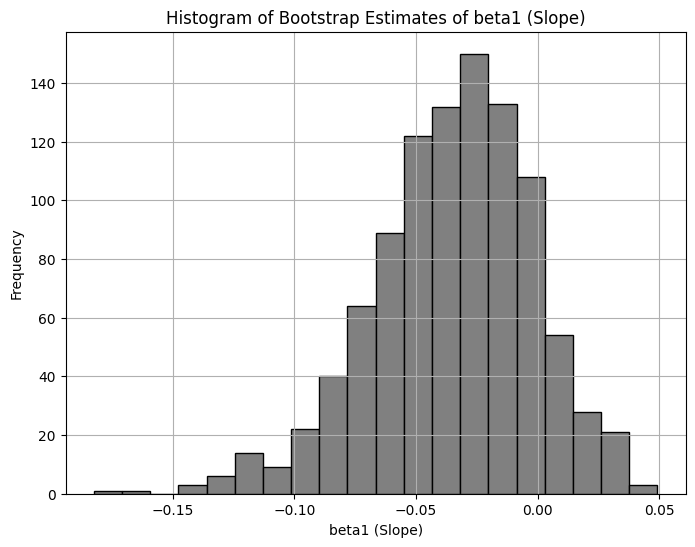

In [ ]:
# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(bootstrap_betas, bins=20, color='gray', edgecolor='black')
plt.title('Histogram of Bootstrap Estimates of beta1 (Slope)')
plt.xlabel('beta1 (Slope)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()